In [5]:
%load_ext autoreload
%autoreload 2

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
The log likelihood of the GBM is 455.99.


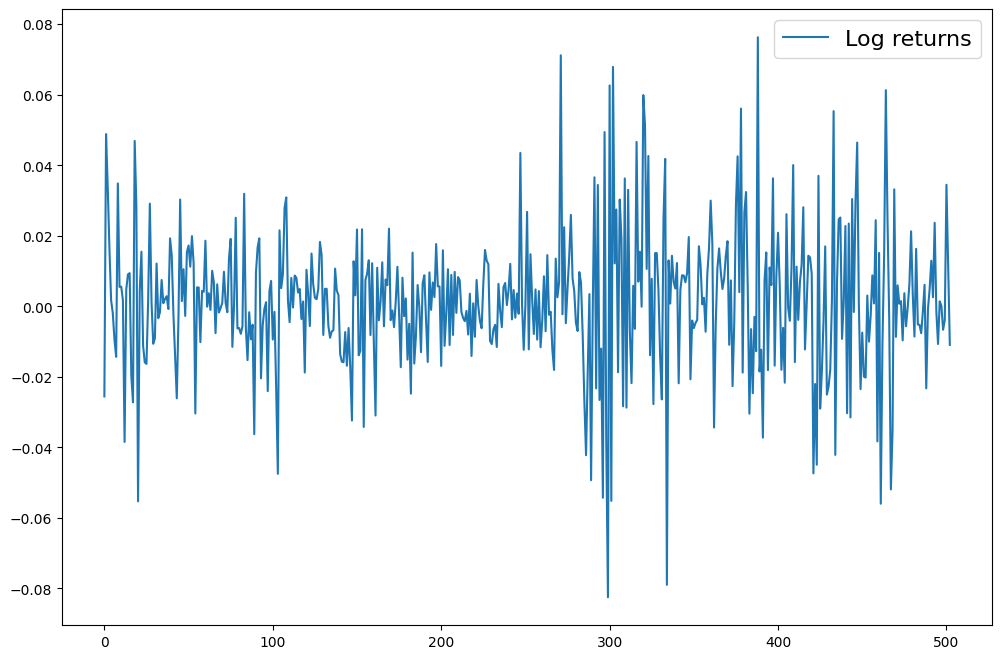

In [6]:
from brownian import log_likelihood, estimate_gbm_parameters
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Download the data.
stock = "AMZN"
data = yf.download(stock, start="2019-01-01", end="2020-12-31")
data_future = yf.download(stock, start="2021-01-01", end="2021-12-31")

# Extract the adjusted closing prices.
prices = data["Adj Close"].values
prices_future = data_future["Adj Close"].values

# Compute the log returns.
log_returns = np.log(prices[1:]/prices[:-1])
log_returns_future = np.log(prices_future[1:]/prices_future[:-1])

# Set the time step.
dt = 1/252

# Estimate the parameters of the GBM.
mu, sigma = estimate_gbm_parameters(prices, dt)


# Compute the log likelihood of the GBM.
ll = log_likelihood(np.array([mu, sigma]), prices_future, dt)
print(f"The log likelihood of the GBM is {ll:.2f}.")


# Plot the log returns.
plt.figure(figsize=(12, 8))
plt.plot(log_returns, label="Log returns")
plt.legend(fontsize=16)
plt.show()


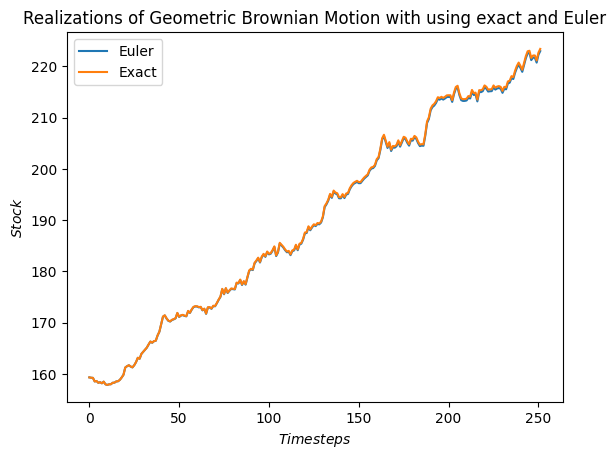

In [7]:
# Compare

T = 1
n = len(prices_future)
dt = T/n
x0 = prices_future[0]

#np.random.seed(42) #This one can be included to use the same simulations every time the code is run.
Stock = np.zeros((n+1,2))
Stock[0,0] = x0
Stock[0,1] = x0

dWt = np.random.normal(0, np.sqrt(dt), size=(1, n)).T

for i in range(1,n+1,1):
    Stock[i,0] = Stock[i-1,0] +(mu-sigma**2/2)*Stock[i-1,0]*dt + sigma*Stock[i-1,0]*dWt[i-1,0]
    Stock[i,1] = Stock[i-1,1]*np.exp((mu-sigma**2/2)*dt + sigma*dWt[i-1,0])

plt.plot(Stock)
plt.xlabel("$Time steps$")
plt.legend(['Euler', 'Exact'])
plt.ylabel("$Stock$")
plt.title(
    "Realizations of Geometric Brownian Motion with using exact and Euler"
)
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_gbm(prices, mu=None, sigma=None, dt=None, num_simulations=1000, num_periods=252):
    # Sample stock data (replace with your actual data)
    stock_prices = prices

    # Calculate logarithmic returns
    returns = np.log(np.array(stock_prices[1:]) / np.array(stock_prices[:-1]))

    # Set the time step.
    if dt is None:
        dt = 1 / len(stock_prices)

    # Estimate the parameters of the GBM.
    if mu is None or sigma is None:
        mu, sigma = estimate_gbm_parameters(prices, dt)

    # Set parameters
    initial_price = stock_prices[0]
    if num_periods is None:
        num_periods = len(stock_prices)

    # Choose interest rate (r)
    interest_rate = 0.05  # Replace with an appropriate value

    # Simulate GBM
    simulated_prices = np.zeros((num_simulations, num_periods))
    simulated_prices[:, 0] = initial_price

    for i in range(num_simulations):
        for j in range(1, num_periods):
            z = np.random.normal(0, 1)
            simulated_prices[i, j] = simulated_prices[i, j-1] * np.exp(
                (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z
            )

    return simulated_prices, dt


mu = 0.7602, sigma = 0.0237


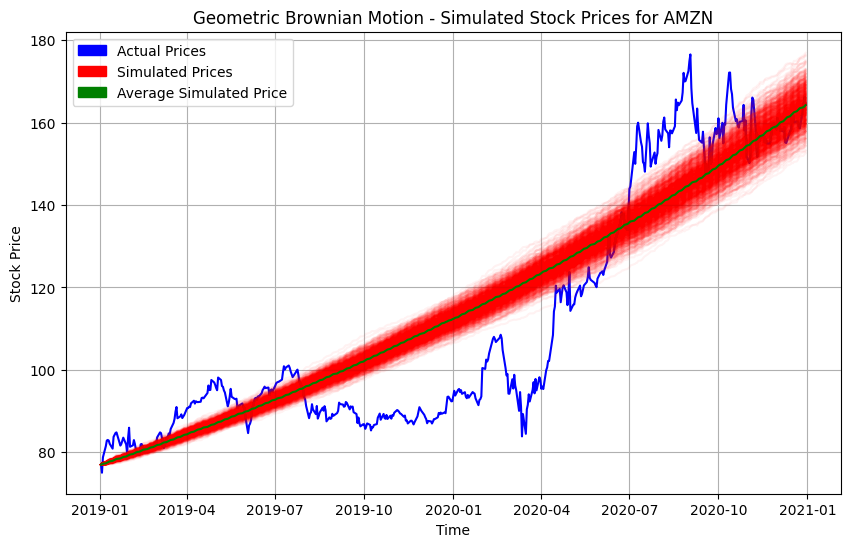

In [9]:
import matplotlib.patches as mpatches
from brownian import plot_gbm
# import matplotlib.pyplot as plt
num_periods = len(prices)
dt = 1 / num_periods

mu, sigma = estimate_gbm_parameters(prices, dt)
print(f"mu = {mu:.4f}, sigma = {sigma:.4f}")

simulated_prices, dt = simulate_gbm(prices, mu=mu, sigma=sigma, dt=dt, num_simulations=1000, num_periods=num_periods)

plot_gbm(data.index, prices, simulated_prices, stock)


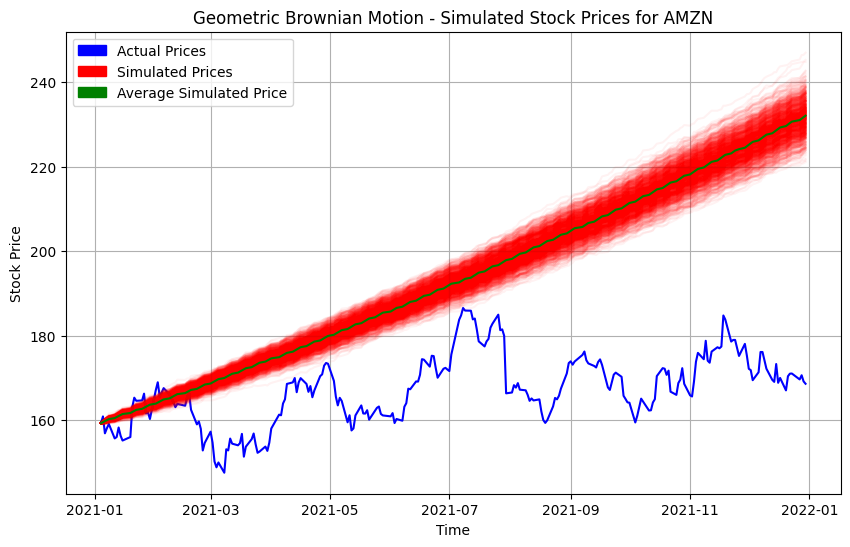

In [10]:
num_periods = len(prices_future)
simulated_prices, dt = simulate_gbm(prices_future, mu=mu, sigma=sigma, dt=dt, num_simulations=1000, num_periods=num_periods)

plot_gbm(data_future.index, prices_future, simulated_prices, stock)

# Options Pricing

In [11]:
import math

def compute_european_call_bounds(S, K, r, T, sigma):
    upper_bound = S
    lower_bound = max(0, S - K * math.exp(-r * T))
    return lower_bound, upper_bound

def compute_european_put_bounds(S, K, r, T, sigma):
    upper_bound = K * math.exp(-r * T)
    lower_bound = max(0, K * math.exp(-r * T) - S)
    return lower_bound, upper_bound

def compute_american_put_bounds(S, K, r, T, sigma):
    upper_bound = K * math.exp(-r * T)
    lower_bound = max(0, K * math.exp(-r * T) - S)
    return lower_bound, upper_bound

# Example usage
s_data = yf.download(stock, start="2022-12-01", end="2022-12-31")
S = s_data.iloc[-1]["Adj Close"]
K = 85
r = 0.05
T = 3 / 12
sigma = sigma

european_call_lower, european_call_upper = compute_european_call_bounds(S, K, r, T, sigma)
european_put_lower, european_put_upper = compute_european_put_bounds(S, K, r, T, sigma)
american_put_lower, american_put_upper = compute_american_put_bounds(S, K, r, T, sigma)

print("European ATM Call Option Bounds:", [european_call_lower, european_call_upper])
print("European ATM Put Option Bounds:", [european_put_lower, european_put_upper])
print("American ATM Put Option Bounds:", [american_put_lower, american_put_upper])


[*********************100%***********************]  1 of 1 completed
European ATM Call Option Bounds: [0.055886958020082034, 84.0]
European ATM Put Option Bounds: [0, 83.94411304197992]
American ATM Put Option Bounds: [0, 83.94411304197992]


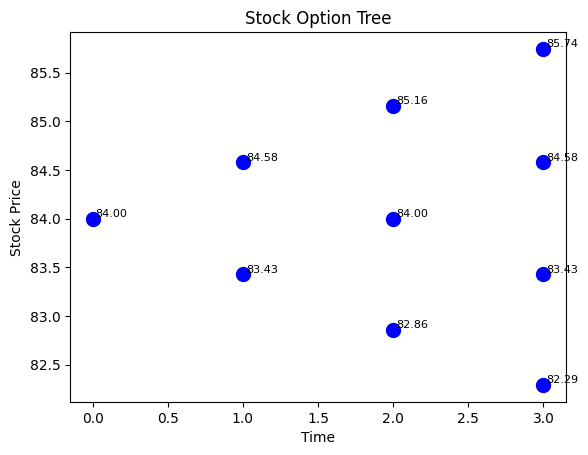

The price of the European call option is 0.38.


In [12]:
from optionspricing import OptionPricer

# Set the parameters.
N = 3 # Number of time steps

# Create the option pricer.
pricer = OptionPricer(S, K, T, r, sigma, N, is_american=False)
price = pricer.price(is_call=True)
print(f"The price of the European call option is {price:.2f}.")


Binomial Model

In [13]:
from blacksholeshedging import black_scholes_call, black_scholes_put

# Calculate the Black-Scholes price
call_price = black_scholes_call(S, K, r, T, sigma)
put_price = black_scholes_put(S, K, r, T, sigma)

print("Black-Scholes call price:", call_price)
print("Black-Scholes put price:", put_price)

Black-Scholes call price: 0.42614832228092325
Black-Scholes put price: 0.3702613642608412


Illustrate that
the price computed by the binomial model converges to the Black-Scholes price when ∆t → 0 (or
equivalently n →∞).

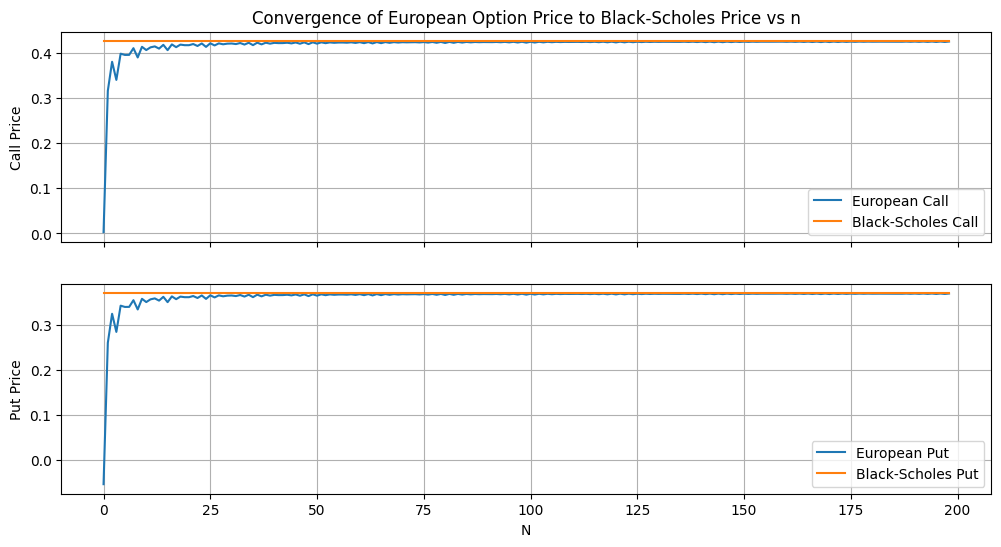

In [14]:
eu_calls = []
eu_puts = []
bs_calls = []
bs_puts = []

for i in list(range(1, 200)):
    N = i
    pricer = OptionPricer(S, K, T, r, sigma, N, is_american=False)

    call_price = pricer.price(is_call=True, plot=False)
    put_price = pricer.price(is_call=False, plot=False)
    eu_calls.append(call_price)
    eu_puts.append(put_price)

    call_price = black_scholes_call(S, K, r, T, sigma)
    bs_calls.append(call_price)

    put_price = black_scholes_put(S, K, r, T, sigma)
    bs_puts.append(put_price)

fig, ax = plt.subplots(nrows=2, figsize=(12, 6), sharex=True)
ax[0].plot(eu_calls, label="European Call")
ax[0].plot(bs_calls, label="Black-Scholes Call")
ax[0].set_title("Convergence of European Option Price to Black-Scholes Price vs n")
ax[0].legend()
ax[0].set_ylabel("Call Price")
ax[0].grid()

ax[1].plot(eu_puts, label="European Put")
ax[1].plot(bs_puts, label="Black-Scholes Put")
ax[1].legend()
ax[1].set_xlabel("N")
ax[1].set_ylabel("Put Price")
ax[1].grid()
plt.show()

Also, in the binomial model, compute the prices of both an ATM European put option and an
ATM American put option.

In [15]:
from optionspricing import OptionPricer

eu_option = OptionPricer(K, S, T, r, sigma, N, is_american=False)
call_price = eu_option.price(is_call=True, plot=False, verbose=False)
put_price = eu_option.price(is_call=False, plot=False, verbose=False)

#print("Binomial European call price:", call_price)
print("Binomial European put price:", put_price)


us_option = OptionPricer(K, S, T, r, sigma, N, is_american=True)
call_price = us_option.price(is_call=True, plot=False, verbose=False)
put_price = us_option.price(is_call=False, plot=False, verbose=False)

#print("Binomial American call price:", call_price)
print("Binomial American put price:", put_price)



Binomial European put price: 0.007400640885305152
Binomial American put price: 0.011368782271616931


Illustrate the Black-Scholes price of a European call option as a function of the option’s strike price.

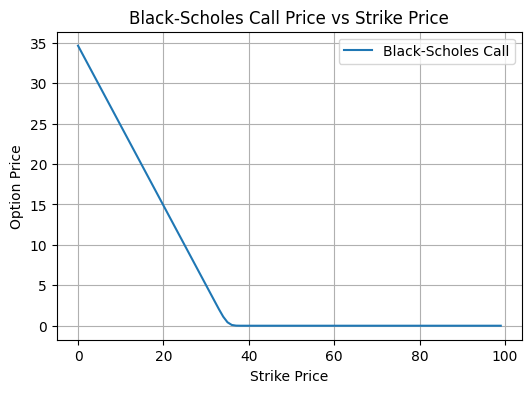

In [16]:
# Illustrate the Black-Scholes price of a European call option as a function of the option’s strike price.
eu_calls = []
bs_calls = []

for i in list(range(50, 150)):
    K = i
    eu_option = OptionPricer(S, K, T, r, sigma, 1, is_american=False)
    call_price = eu_option.price(True, plot=False, verbose=False)
    eu_calls.append(call_price)

    call_price = black_scholes_call(S, K, r, T, sigma)
    bs_calls.append(call_price)

fig, ax = plt.subplots(nrows=1, figsize=(6, 4))
#ax.plot(eu_calls, label="European Call (N=1)")
ax.plot(bs_calls, label="Black-Scholes Call")
ax.set_title("Black-Scholes Call Price vs Strike Price")
ax.legend()
ax.set_xlabel("Strike Price")
ax.set_ylabel("Option Price")
ax.grid()
plt.show()

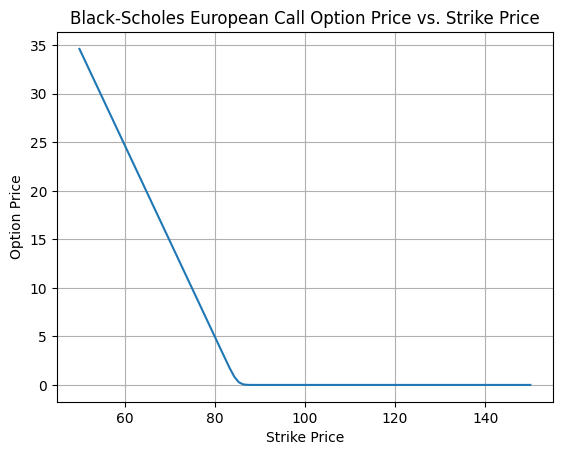

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def calculate_black_scholes_call(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Define parameters
r = 0.05  # Risk-free interest rate
T = 3/12  # Time to expiration (in years)

# Define strike price range
strike_prices = np.linspace(50, 150, 100)

# Calculate option prices for each strike price
call_prices = [calculate_black_scholes_call(S, K, r, T, sigma) for K in strike_prices]

# Plot the option prices against strike prices
plt.plot(strike_prices, call_prices)
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.title("Black-Scholes European Call Option Price vs. Strike Price")
plt.grid(True)
plt.show()

Consider the European options that were priced earlier. Download data for your chosen stock from
January 1, 2023, to March 31, 2023 (the expiry of the option). You want to delta hedge the options over
the lifetime of the option.
* Calculate the initial Delta of the options and re-balance this hedge daily over the lifetime of the
options. Illustrate your results.
* Compare the hedging costs with the theoretical option prices.
* Redo the Delta-hedge using less frequent rebalancing and discuss if you obtain the expected results

In [18]:
import yfinance as yf

data = yf.download("AMZN", start="2023-01-01", end="2023-03-31")
stocks = data['Close'].values

[*********************100%***********************]  1 of 1 completed


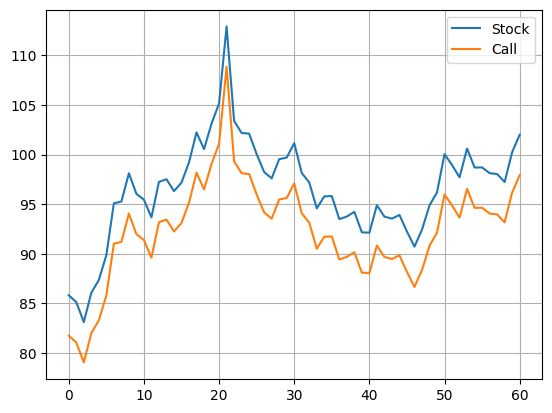

In [19]:
calls = []

K = stocks[0]
r = 0.05
T = len(stocks)

for i in range(0, len(stocks)):
  bs_call = black_scholes_call(stocks[i], K, r, T, sigma)
  calls.append(bs_call)

plt.plot(stocks, label="Stock")
plt.plot(calls, label="Call")
plt.grid()
plt.legend()
plt.show()

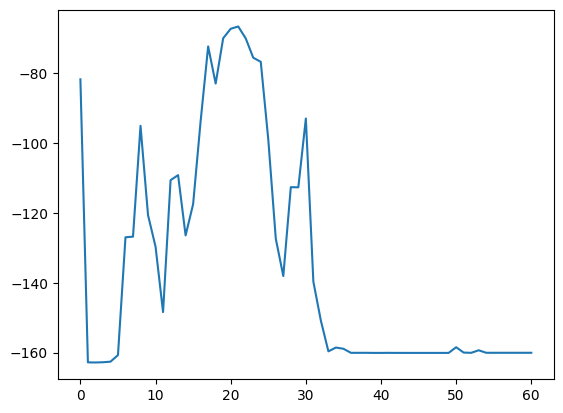

In [20]:
from blacksholeshedging import black_scholes_delta, hedge_rebalancing
T = len(stocks)
delta = black_scholes_delta(stocks[0], 105, r, T, sigma)
profit, hedges = hedge_rebalancing(stocks, delta, calls, 2/T, 105, r, sigma)
plt.plot(hedges)
plt.show()

In [21]:
len(calls)

61

[*********************100%***********************]  1 of 1 completed


<AxesSubplot: xlabel='Date'>

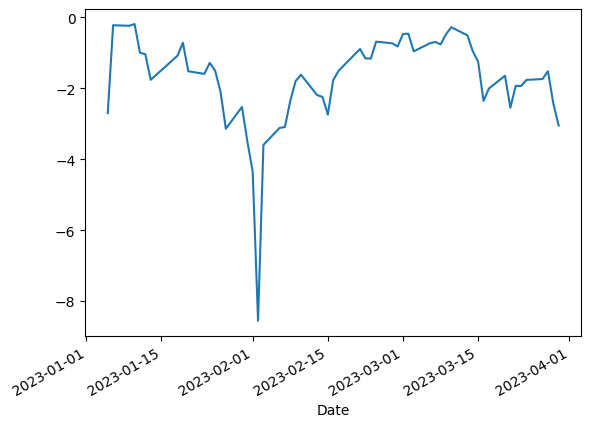

In [22]:
import numpy as np
import pandas as pd
import scipy.stats as si





# Load the stock data
stock_data = yf.download("AMZN", start="2023-01-01", end="2023-03-31")

# Define the option parameters
S = stocks[0]  # time to maturity in years
dt = 2 / len(stock_data)
tte = (len(stock_data) - i) * dt
# Calculate the option price and Delta using Black-Scholes formula
d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
delta = si.norm.cdf(d1)

# Calculate the daily returns
returns = stock_data['Close'].pct_change().dropna()

# Create a DataFrame to store the hedging results
hedge_results = pd.DataFrame(index=returns.index, columns=['option_delta', 'hedge_position', 'hedge_pnl'])

# Initialize the hedge
option_delta = delta
hedge_position = option_delta * S
hedge_results.loc[returns.index[0], 'option_delta'] = option_delta
hedge_results.loc[returns.index[0], 'hedge_position'] = hedge_position

# Perform delta hedging over the lifetime of the option
for i in range(1, len(returns)):
    # Calculate the new option Delta using the new stock price
    S_new = stock_data.loc[returns.index[i], 'Close']
    d1_new = (np.log(S_new/K) + (r + 0.5*sigma**2)*tte) / (sigma*np.sqrt(tte))
    option_delta_new = si.norm.cdf(d1_new)
    hedge_results.loc[returns.index[i], 'option_delta'] = option_delta_new
    
    # Calculate the change in the hedge position and P&L
    hedge_position_change = option_delta_new * S_new - option_delta * S
    hedge_pnl = hedge_position_change - (hedge_position_change / S) * S_new
    
    # Update the hedge position and option Delta
    hedge_position += hedge_position_change
    option_delta = option_delta_new
    
    # Store the results
    hedge_results.loc[returns.index[i], 'hedge_position'] = hedge_position
    hedge_results.loc[returns.index[i], 'hedge_pnl'] = hedge_pnl

# Plot the results
hedge_results['hedge_pnl'].plot()


In [23]:
d1

16.544850088087305

[*********************100%***********************]  1 of 1 completed


C:\Users\Ferenc Fodor\AppData\Local\Temp\ipykernel_20584\3932681705.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  d1_new = (np.log(S_new/K) + (r + 0.5*sigma**2)*(T - i/t)) / (sigma*np.sqrt(T - i/t))
C:\Users\Ferenc Fodor\AppData\Local\Temp\ipykernel_20584\3932681705.py:35: RuntimeWarning: invalid value encountered in sqrt
  d1_new = (np.log(S_new/K) + (r + 0.5*sigma**2)*(T - i/t)) / (sigma*np.sqrt(T - i/t))
C:\Users\Ferenc Fodor\AppData\Local\Temp\ipykernel_20584\3932681705.py:36: RuntimeWarning: invalid value encountered in sqrt
  option_price_new = S_new * si.norm.cdf(d1_new) - K * np.exp(-r*(T - i/252)) * si.norm.cdf(d1_new - sigma*np.sqrt(T - i/t))


<AxesSubplot: xlabel='Date'>

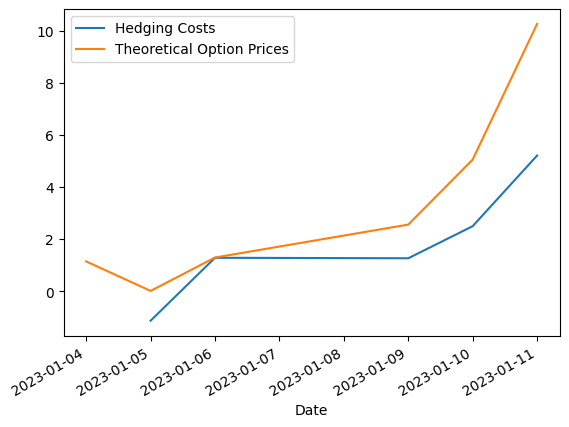

In [24]:
import numpy as np
import pandas as pd
import scipy.stats as si

# Load the stock data
stock_data = yf.download(stock, start="2023-01-01", end="2023-03-31")


# Define the option parameters
S = stock_data['Adj Close'][0]  # current stock price
K = S  # strike price
r = 0.05  # risk-free rate
sigma = 0.0237  # volatility
T = 0.25  # time to maturity in years
t = 20

# Calculate the option price and Delta using Black-Scholes formula
d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
option_price = S * si.norm.cdf(d1) - K * np.exp(-r*T) * si.norm.cdf(d1 - sigma*np.sqrt(T))
delta = si.norm.cdf(d1)

# Calculate the daily returns
returns = stock_data['Adj Close'].pct_change().dropna()

# Create a DataFrame to store the hedging results
hedge_results = pd.DataFrame(index=returns.index, columns=['option_price', 'hedge_pnl'])

# Initialize the hedge
hedge_results.loc[returns.index[0], 'option_price'] = option_price

# Perform delta hedging over the lifetime of the option
for i in range(1, len(returns)):
    # Calculate the new option price using the new stock price
    S_new = stock_data.loc[returns.index[i], 'Adj Close']
    d1_new = (np.log(S_new/K) + (r + 0.5*sigma**2)*(T - i/t)) / (sigma*np.sqrt(T - i/t))
    option_price_new = S_new * si.norm.cdf(d1_new) - K * np.exp(-r*(T - i/252)) * si.norm.cdf(d1_new - sigma*np.sqrt(T - i/t))
    hedge_results.loc[returns.index[i], 'option_price'] = option_price_new
    
    # Calculate the change in the hedge P&L
    hedge_pnl = option_price_new - option_price
    
    # Update the option price
    option_price = option_price_new
    
    # Store the results
    hedge_results.loc[returns.index[i], 'hedge_pnl'] = hedge_pnl

# Compare the hedging costs with the theoretical option prices
hedge_pnl = hedge_results['hedge_pnl'].cumsum()
theoretical_option_prices = hedge_results['option_price'].cumsum()

# Plot the comparison
comparison = pd.DataFrame({'Hedging Costs': hedge_results['hedge_pnl'], 'Theoretical Option Prices': hedge_results['option_price']})
comparison.plot()


In [25]:
hedge_results

,option_price,hedge_pnl
Date,,
2023-01-04,1.14184,NaN
2023-01-05,0.009898,-1.131942
2023-01-06,1.292008,1.282111
2023-01-09,2.555122,1.263113
2023-01-10,5.048784,2.493663
2023-01-11,10.251947,5.203162
2023-01-12,NaN,NaN
2023-01-13,NaN,NaN
2023-01-17,NaN,NaN


<AxesSubplot: xlabel='Date'>

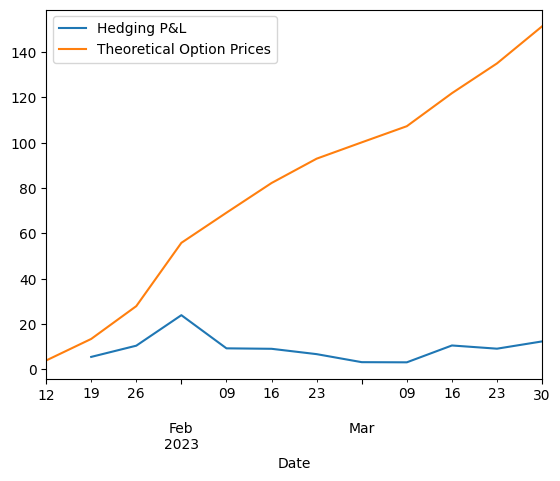

In [26]:
import numpy as np
import pandas as pd
import scipy.stats as si

# Define the option parameters
S = stock_data['Adj Close'][0]  # current stock price
K = S  # strike price
r = 0.05  # risk-free rate
sigma = 0.2  # volatility
T = 0.25  # time to maturity in years

# Calculate the option price and Delta using Black-Scholes formula
d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
option_price = S * si.norm.cdf(d1) - K * np.exp(-r*T) * si.norm.cdf(d1 - sigma*np.sqrt(T))
delta = si.norm.cdf(d1)


# Calculate the weekly returns
weekly_returns = stock_data['Adj Close'].resample('W-THU').ffill().pct_change().dropna()

# Create a DataFrame to store the hedging results
hedge_results = pd.DataFrame(index=weekly_returns.index, columns=['option_price', 'hedge_pnl'])

# Initialize the hedge
hedge_results.loc[weekly_returns.index[0], 'option_price'] = option_price

# Perform delta hedging over the lifetime of the option with weekly rebalancing
for i in range(1, len(weekly_returns)):
    # Calculate the new option price using the new stock price
    S_new = stock_data.loc[weekly_returns.index[i], 'Adj Close']
    d1_new = (np.log(S_new/K) + (r + 0.5*sigma**2)*(T - (i/52))) / (sigma*np.sqrt(T - (i/52)))
    option_price_new = S_new * si.norm.cdf(d1_new) - K * np.exp(-r*(T - (i/52))) * si.norm.cdf(d1_new - sigma*np.sqrt(T - (i/52)))
    hedge_results.loc[weekly_returns.index[i], 'option_price'] = option_price_new
    
    # Calculate the change in the hedge P&L
    hedge_pnl = option_price_new - option_price
    
    # Update the option price
    option_price = option_price_new
    
    # Store the results
    hedge_results.loc[weekly_returns.index[i], 'hedge_pnl'] = hedge_pnl

# Compare the hedging costs with the theoretical option prices
hedge_pnl = hedge_results['hedge_pnl'].cumsum()
theoretical_option_prices = hedge_results['option_price'].cumsum()

# Plot the comparison
comparison = pd.DataFrame({'Hedging P&L': hedge_pnl, 'Theoretical Option Prices': theoretical_option_prices})
comparison.plot()


# VASICEK

Let's assume the Vasicek model is given by the following stochastic differential equation:

dr(t) = a(b - r(t))dt + σdW(t)

where:

r(t) is the short-term interest rate at time t <br>
a is the speed of mean reversion<br>
b is the long-term mean interest rate<br>
σ is the volatility of the interest rate<br>
dW(t) is the Wiener process (Brownian motion) at time t

In [27]:
data = pd.read_excel('RatesComma.xlsx', index_col=0)
data = pd.DataFrame(data['Group 12'].values, index=data.index, columns=['interest'])

KeyboardInterrupt: 

Text(0.5, 0, 'Time (years)')

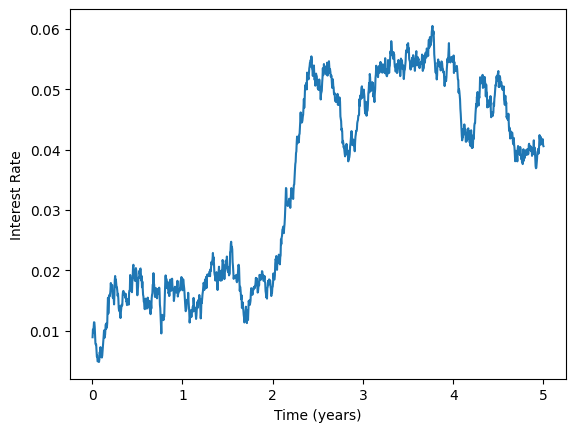

In [ ]:
fig, ax = plt.subplots()
data.plot(ax=ax, legend=False)
ax.set_ylabel('Interest Rate')
ax.set_xlabel('Time (years)')

In [ ]:
from scipy.optimize import minimize

# Convert the data to a numpy array
r = data['interest'].values

# Define the moments of the interest rate data
mean_r = np.mean(r)
var_r = np.var(r, ddof=1)
std_r = np.std(r, ddof=1)

# Define the moment equations for parameter estimation
def moment_equations(params):
    a, b, sigma = params
    moment1 = b - (a / sigma**2) * (mean_r - b) * (1 - np.exp(-a))
    moment2 = (sigma**2 / (2*a)) * (1 - np.exp(-2*a)) - var_r
    moment3 = (sigma**2 / a) * (1 - np.exp(-a)) - std_r**2
    return moment1, moment2, moment3

# Define the objective function for parameter estimation
def objective_function(params):
    moment1, moment2, moment3 = moment_equations(params)
    return moment1**2 + moment2**2 + moment3**2

# Perform parameter estimation using the method of moments
initial_guess = [0.1, 0.05, 0.02]  # Initial guess for the parameters [a, b, sigma]
result = minimize(objective_function, initial_guess, method='Nelder-Mead')

# Extract the estimated parameters
estimated_params = result.x
a_est, b_est, sigma_est = estimated_params

# Print the estimated parameters
print('Estimated Parameters:')
print('a:', a_est)
print('b:', b_est)
print('sigma:', sigma_est)

Estimated Parameters:
a: 0.14401638329949845
b: 0.034099547230292654
sigma: 0.017484521098577517


<h3>Calculation of exposure</h3>
For each of the swap contracts, use interest rate simulations to calculate the future values of the interest
swaps. Use these simulated values to find the expected exposure, the peak exposure (97.5%), and the
maximum peak exposure.

In [ ]:
import numpy as np

# Swap details
swap1_notional = 2e6  # $2 million
swap1_fixed_rate = 0.02  # 2%
swap1_tenor = 10  # 10 years

swap2_notional = 8e6  # $8 million
swap2_fixed_rate = 0.0  # To be determined such that the initial value is zero
swap2_tenor = 7  # 7 years

swap3_notional = 6e6  # $6 million
swap3_fixed_rate = 0.03  # 3%
swap3_tenor = 4  # 4 years

# Interest rate simulation data (an array of simulated interest rate paths)
# Each row represents a different simulation path, and each column represents the interest rate at a particular time step
interest_rate_simulations = data['interest'].values

# Function to calculate the future value of an interest rate swap given an interest rate path
def calculate_future_value(swap_notional, swap_fixed_rate, swap_tenor, interest_rates):
    future_value = swap_notional * (swap_fixed_rate - interest_rates) * (1 - (1 + interest_rates)**(-swap_tenor)) / interest_rates
    return future_value

# Calculate the future values of the interest swaps for each simulation path
swap1_future_values = calculate_future_value(swap1_notional, swap1_fixed_rate, swap1_tenor, interest_rate_simulations)
swap2_future_values = calculate_future_value(swap2_notional, swap2_fixed_rate, swap2_tenor, interest_rate_simulations)
swap3_future_values = calculate_future_value(swap3_notional, swap3_fixed_rate, swap3_tenor, interest_rate_simulations)

# Calculate the expected exposure, peak exposure (97.5%), and maximum peak exposure
expected_exposure = np.mean(np.maximum(swap1_future_values, 0) + np.maximum(swap2_future_values, 0) + np.maximum(swap3_future_values, 0))
peak_exposure_975 = np.percentile(swap1_future_values + swap2_future_values + swap3_future_values, 97.5)
maximum_peak_exposure = np.max(np.maximum.accumulate(swap1_future_values + swap2_future_values + swap3_future_values))

# Print the results
print("Expected Exposure: $", expected_exposure)
print("Peak Exposure (97.5%): $", peak_exposure_975)
print("Maximum Peak Exposure: $", maximum_peak_exposure)


Expected Exposure: $ 163095.04580120402
Peak Exposure (97.5%): $ 110099.39333326323
Maximum Peak Exposure: $ 629324.9640399916


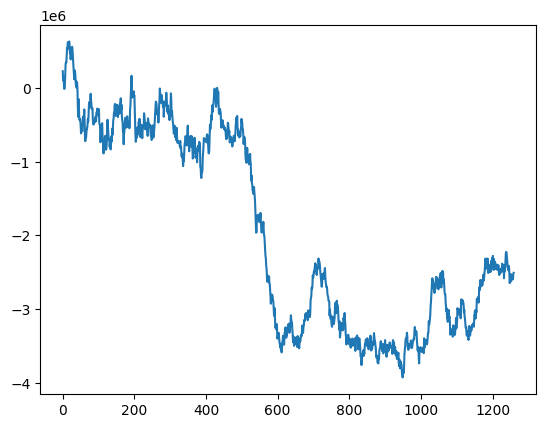

In [ ]:
plt.plot(swap1_future_values + swap2_future_values + swap3_future_values)

In [ ]:
import numpy as np

# Swap details
swap1_notional = 2e6  # $2 million
swap2_notional = 8e6  # $8 million
swap3_notional = 6e6  # $6 million

# Interest rate simulation data (an array of simulated interest rate paths)
# Each row represents a different simulation path, and each column represents the interest rate at a particular time step
interest_rate_simulations = data['interest'].values

# Recovery rate
recovery_rate = 0.4  # 40%

# Table data (Tenor in bps)
table_data = {
    "1Y": [362, 836],
    "2Y": [404, 713],
    "3Y": [412, 654],
    "4Y": [403, 599],
    "5Y": [416, 555],
    "10Y": [423, 522]
}

# Function to calculate the CVA charge for a swap on a given date
def calculate_cva_charge(swap_notional, tenor, interest_rates, table_data, recovery_rate):
    tenor_data = table_data[tenor]
    exposure = swap_notional * tenor_data[1] / 10000  # Convert bps to percentage
    probability_default = np.mean(interest_rates[:int(tenor[:-1]) * 252] > tenor_data[0] / 10000)  # Convert bps to percentage and calculate the default probability
    cva_charge = exposure * probability_default * (1 - recovery_rate)
    return cva_charge

# Calculate the CVA charge for each swap on the specified dates
cva_charge_1 = calculate_cva_charge(swap1_notional, "10Y", interest_rate_simulations, table_data, recovery_rate)
cva_charge_2 = calculate_cva_charge(swap2_notional, "5Y", interest_rate_simulations, table_data, recovery_rate)
cva_charge_3 = calculate_cva_charge(swap3_notional, "4Y", interest_rate_simulations, table_data, recovery_rate)

# Print the CVA charges
print("CVA Charge on March 10 for Swap 1: $", cva_charge_1)
print("CVA Charge on March 14 for Swap 1: $", cva_charge_1)
print("CVA Charge on March 10 for Swap 2: $", cva_charge_2)
print("CVA Charge on March 14 for Swap 2: $", cva_charge_2)
print("CVA Charge on March 10 for Swap 3: $", cva_charge_3)
print("CVA Charge on March 14 for Swap 3: $", cva_charge_3)


CVA Charge on March 10 for Swap 1: $ 26994.85714285714
CVA Charge on March 14 for Swap 1: $ 26994.85714285714
CVA Charge on March 10 for Swap 2: $ 119668.57142857142
CVA Charge on March 14 for Swap 2: $ 119668.57142857142
CVA Charge on March 10 for Swap 3: $ 90063.92857142858
CVA Charge on March 14 for Swap 3: $ 90063.92857142858


In [30]:
simulated_prices[0]

array([159.33149719, 159.49588616, 159.76821768, 160.11233344,
       160.53386859, 160.6904137 , 160.91847271, 161.09162149,
       161.3425983 , 161.40729214, 161.32632141, 161.7559954 ,
       161.9930617 , 162.1425688 , 162.29498859, 162.610568  ,
       162.91512915, 162.91777563, 163.27988309, 163.42001874,
       163.75875926, 163.92057969, 164.22015207, 164.2200628 ,
       164.47723998, 164.65395722, 164.7665146 , 165.12058994,
       165.38441342, 165.53976932, 165.52084185, 165.71544203,
       166.16641617, 166.43807601, 166.4257932 , 166.57381752,
       166.76334891, 166.87003702, 167.16263398, 167.59226233,
       167.90882841, 168.28853505, 168.67478071, 169.02686229,
       168.92885386, 169.30871087, 169.86021917, 170.15742306,
       169.92772718, 170.21645316, 170.60372892, 170.79442565,
       170.99940238, 171.36416503, 171.41492162, 171.38134752,
       171.5879314 , 171.89304846, 171.89575365, 171.91902193,
       172.28635132, 172.5452125 , 172.89708358, 172.83

In [49]:
import numpy as np
from scipy.stats import norm
import yfinance as yf

# Function to calculate the initial delta of an option
def calculate_initial_delta(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    initial_delta = np.exp(-r * T) * norm.cdf(d1)
    return initial_delta

def calcuate_delta(S, K, r, T, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    delta = np.exp(-r * T) * norm.cdf(d1)
    return delta

# Function to rebalance the hedge daily and calculate hedging costs
def delta_hedging(option_type, S, K, r, T, sigma, daily_prices):
    initial_delta = calculate_initial_delta(S, K, r, T, sigma)
    daily_deltas = [initial_delta]
    hedging_costs = [0.0]

    for i in range(1, len(daily_prices)):
        T = (len(daily_prices) - i) / 252.0
        K = daily_prices[i]
        # Calculate the daily change in stock price
        delta_S = daily_prices[i] - daily_prices[i-1]
        delta = calcuate_delta(S, K, r, T, sigma)
        
        # Adjust the delta based on the change in stock price
        if option_type == 'call':
            delta = daily_deltas[i-1] + delta_S
        elif option_type == 'put':
            delta = daily_deltas[i-1] - delta_S
        
        # Calculate the hedging costs (assuming no transaction costs)
        cost = delta - daily_deltas[i-1]
        hedging_costs.append(cost)
        
        # Update the delta for the next day
        daily_deltas.append(delta)
    
    return daily_deltas, hedging_costs

# Example usage

stock_data = yf.download("AMZN", start="2023-01-01", end="2023-03-31")
# Define the option parameters
S = stock_data['Adj Close'][0]  # current stock price
K = S  # strike price
r = 0.05  # risk-free rate
T = 90 / 365

option_type = 'call'

# Generate example daily stock prices from January 1, 2023, to March 31, 2023
daily_prices = stock_data['Adj Close'].values#np.random.normal(S, 1, 90)

#take every 5th day
daily_prices = daily_prices#[::15]

# Perform delta hedging and calculate hedging costs
daily_deltas, hedging_costs = delta_hedging(option_type, S, K, r, T, sigma, daily_prices)

# Print the daily deltas and hedging costs
for i in range(len(daily_deltas)):
    print(f"Day {i+1}: Delta = {daily_deltas[i]:.4f}, Hedging Cost = {hedging_costs[i]:.4f}")


[*********************100%***********************]  1 of 1 completed
Day 1: Delta = 0.5725, Hedging Cost = 0.0000
Day 2: Delta = 1.1447, Hedging Cost = 0.5722
Day 3: Delta = 1.7166, Hedging Cost = 0.5719
Day 4: Delta = 2.2881, Hedging Cost = 0.5715
Day 5: Delta = 2.8593, Hedging Cost = 0.5712
Day 6: Delta = 3.4301, Hedging Cost = 0.5708
Day 7: Delta = 4.0006, Hedging Cost = 0.5705
Day 8: Delta = 4.5707, Hedging Cost = 0.5701
Day 9: Delta = 5.1405, Hedging Cost = 0.5698
Day 10: Delta = 5.7099, Hedging Cost = 0.5694
Day 11: Delta = 6.2790, Hedging Cost = 0.5691
Day 12: Delta = 6.8477, Hedging Cost = 0.5687
Day 13: Delta = 7.4160, Hedging Cost = 0.5683
Day 14: Delta = 7.9840, Hedging Cost = 0.5680
Day 15: Delta = 8.5515, Hedging Cost = 0.5676
Day 16: Delta = 9.1188, Hedging Cost = 0.5672
Day 17: Delta = 9.6856, Hedging Cost = 0.5668
Day 18: Delta = 10.2520, Hedging Cost = 0.5664
Day 19: Delta = 10.8181, Hedging Cost = 0.5661
Day 20: Delta = 11.3838, Hedging Cost = 0.5657
Day 21: Delta = 1

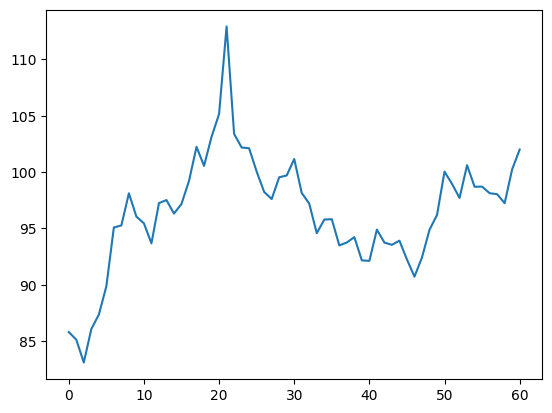

In [34]:
plt.plot(daily_prices)

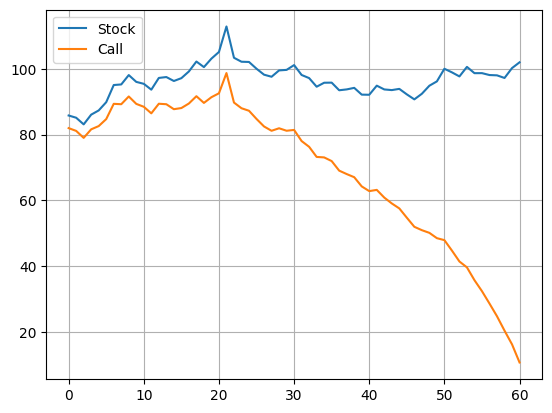

In [45]:
calls = []

K = stocks[0]
r = 0.05
T = len(stocks)

for i in range(0, len(stocks)):
  T = len(stocks) - i
  K = stocks[i]
  bs_call = black_scholes_call(stocks[i], K, r, T, sigma)
  calls.append(bs_call)

plt.plot(stocks, label="Stock")
plt.plot(calls, label="Call")
plt.grid()
plt.legend()
plt.show()

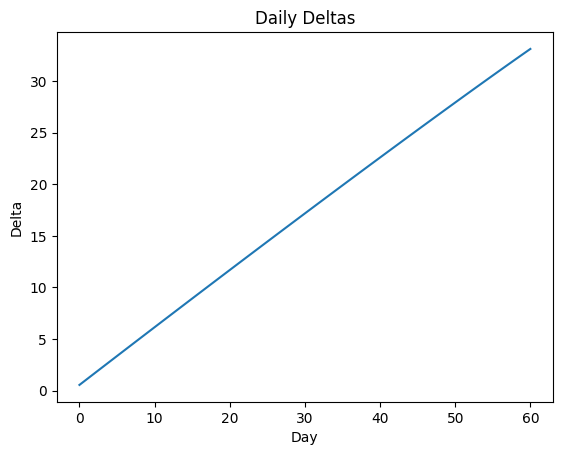

Text(0.5, 1.0, 'Hedging Costs')

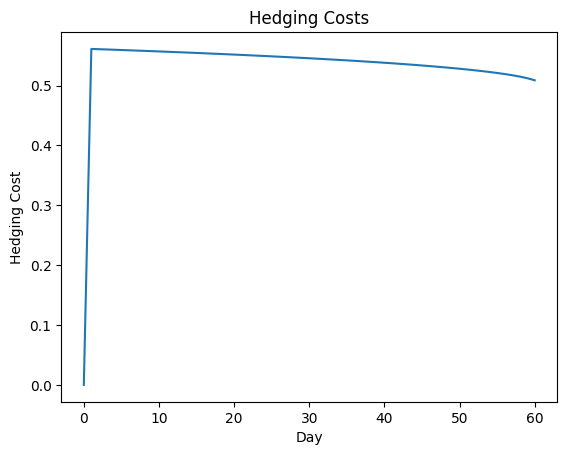

In [48]:
# plot
import matplotlib.pyplot as plt

# Plot the daily deltas
plt.plot(daily_deltas)
plt.xlabel("Day")
plt.ylabel("Delta")
plt.title("Daily Deltas")
plt.show()
# Plot the hedging costs
plt.plot(hedging_costs)
plt.xlabel("Day")
plt.ylabel("Hedging Cost")
plt.title("Hedging Costs")



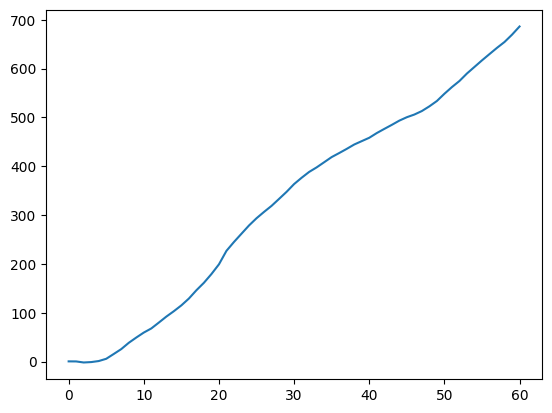

In [40]:
plt.plot(np.cumsum(daily_deltas))

In [31]:

for h in hedging_costs:

[0.0,
 11.360000610351562,
 3.9800033569335938,
 -8.910003662109375,
 9.749999999999998]

In [82]:
import math

def calculate_option_delta(S, K, r, t, sigma):
    d1 = (math.log(S / K) + (r + (sigma ** 2) / 2) * t) / (sigma * math.sqrt(t))
    delta = math.exp(-r * t) * norm_cdf(d1)
    return delta

def norm_cdf(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def calculate_option_price(S, K, r, t, sigma):
    d1 = (math.log(S / K) + (r + (sigma ** 2) / 2) * t) / (sigma * math.sqrt(t))
    d2 = d1 - sigma * math.sqrt(t)
    
    call_price = S * norm_cdf(d1) - K * math.exp(-r * t) * norm_cdf(d2)
    return call_price

def norm_cdf(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def delta_hedging(S, K, r, t, sigma, option_price, target_delta, initial_delta, shares_held):
    current_delta = calculate_option_delta(S, K, r, t, sigma)
    delta_diff = target_delta - current_delta
    shares_to_trade = delta_diff * S
    cash_flow = option_price - (current_delta - initial_delta) * S
    shares_held += shares_to_trade
    return shares_held, cash_flow, current_delta

# Example usage
initial_stock_price = stocks[0]
initial_option_price = 5.0
strike_price = stocks[0]
risk_free_rate = 0.05
time_to_maturity = len(stocks) / 365  # 3 months is 0.25 years
volatility = 0.2
target_delta = 0.75

# Assume you have historical stock price data from January 1, 2023, to March 31, 2023 in a list called "stock_prices"
# Make sure the list length corresponds to the number of trading days within that period

# Calculate initial Delta
initial_delta = calculate_option_delta(initial_stock_price, strike_price, risk_free_rate, time_to_maturity, volatility)

# Perform delta hedging
shares_held = -initial_delta * initial_stock_price
cash_flow = initial_option_price + initial_delta * initial_stock_price

stockprices = stocks
optionsprices = []
sharesheld = []
cashflow = []
deltas = [initial_delta]
for i, stock_price in enumerate(stocks):
    option_price = calculate_option_price(stock_price, strike_price, risk_free_rate, time_to_maturity - (i / 365), volatility)
    
    shares_held, cash_flow, delta = delta_hedging(stock_price, strike_price, risk_free_rate, time_to_maturity - (i / 365), volatility, option_price, target_delta, initial_delta, shares_held)
    intial_delta = delta
    print("Day:", i+1)
    print("Stock Price:", stock_price)
    print("Option Price:", option_price)
    print("Shares Held:", shares_held)
    print("Cash Flow:", cash_flow)
    print("-------------------------")
    optionsprices.append(option_price)
    sharesheld.append(shares_held)
    cashflow.append(cash_flow)
    deltas.append(delta)



Day: 1
Stock Price: 85.81999969482422
Option Price: 3.1584643011496283
Shares Held: -30.423779211972207
Cash Flow: 3.1584643011496283
-------------------------
Day: 2
Stock Price: 85.13999938964844
Option Price: 2.7643831249132305
Shares Held: -10.265403183402846
Cash Flow: 6.08661659949998
-------------------------
Day: 3
Stock Price: 83.12000274658203
Option Price: 1.8113881519359012
Shares Held: 19.205108114234942
Cash Flow: 14.845204296167017
-------------------------
Day: 4
Stock Price: 86.08000183105469
Option Price: 3.217490435987223
Shares Held: 35.05128344924206
Cash Flow: 2.041640961690359
-------------------------
Day: 5
Stock Price: 87.36000061035156
Option Price: 3.9639880658749647
Shares Held: 44.937480762560305
Cash Flow: -3.424954793884024
-------------------------
Day: 6
Stock Price: 89.87000274658203
Option Price: 5.707127095691433
Shares Held: 44.02618688960242
Cash Flow: -12.97565125477546
-------------------------
Day: 7
Stock Price: 95.08999633789062
Option Price:

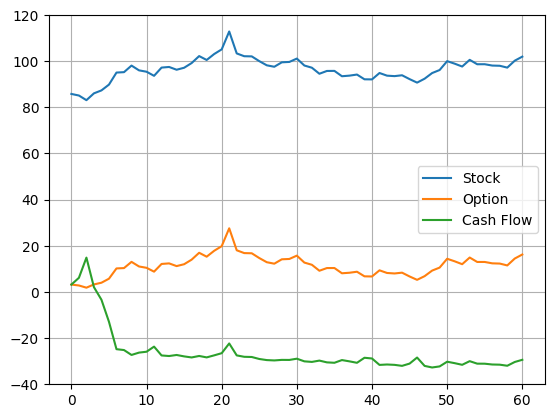

In [83]:
plt.plot(stocks, label="Stock")
plt.plot(optionsprices, label="Option")
#plt.plot(sharesheld, label="Shares Held")
plt.plot(cashflow, label="Cash Flow")
plt.grid()
plt.legend()

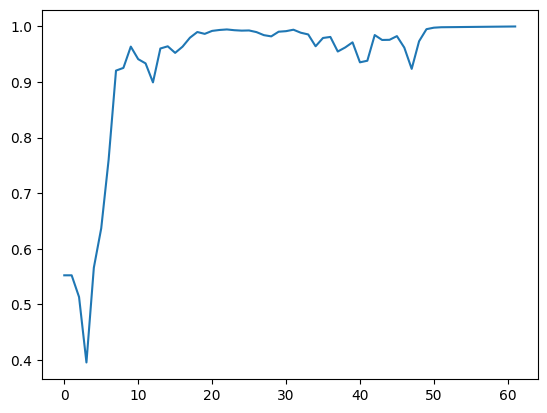

In [84]:
plt.plot(deltas)

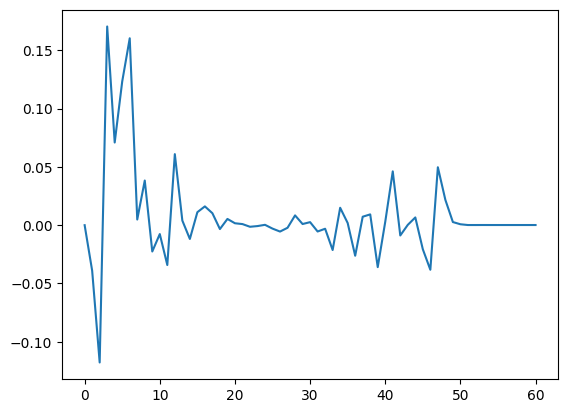

In [85]:
plt.plot(np.diff(deltas))

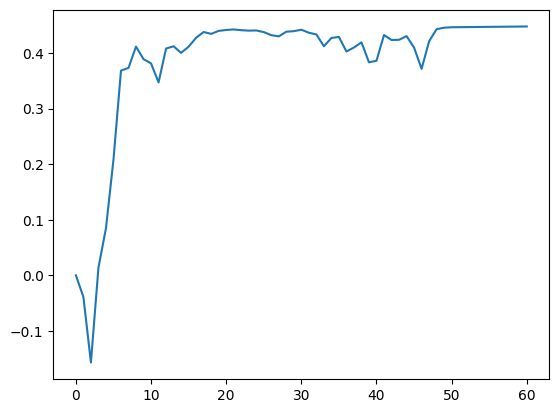

In [86]:
plt.plot(np.cumsum(np.diff(deltas)))

In [97]:
import math

# Function to calculate the Black-Scholes call option price
def calculate_option_price(S, K, r, t, sigma):
    d1 = (math.log(S / K) + (r + (sigma ** 2) / 2) * t) / (sigma * math.sqrt(t))
    d2 = d1 - sigma * math.sqrt(t)
    
    call_price = S * norm_cdf(d1) - K * math.exp(-r * t) * norm_cdf(d2)
    return call_price

def calculate_option_delta(S, K, r, t, sigma):
    d1 = (math.log(S / K) + (r + (sigma ** 2) / 2) * t) / (sigma * math.sqrt(t))
    delta = math.exp(-r * t) * norm_cdf(d1)
    return delta

# Function to calculate the daily delta hedging
def delta_hedging(stock_prices, option_price, deltas, shares_held):
    cash_flows = [0]  # List to store the cash flow for each day
    for i in range(1, len(stock_prices)):
        stock_price = stock_prices[i]
        current_delta = calculate_option_delta(stock_price, strike_price, risk_free_rate, time_to_maturity - (i / 365), volatility)
        delta_diff = deltas[i-1] - current_delta
        deltas.append(current_delta)
        shares_to_trade = delta_diff * stock_price
        cash_flow = option_price - (current_delta - deltas[i-1]) * stock_price
        shares_held += shares_to_trade
        cash_flows.append(cash_flow)
    return shares_held, cash_flows, deltas

# Example usage
initial_stock_price = stocks[0]
initial_option_price = 5.0
strike_price = stocks[0]
risk_free_rate = 0.05
time_to_maturity = len(stocks) / 365  # 3 months is 0.25 years
volatility = 0.237
target_delta = 0.75


# Assume you have historical stock price data from January 1, 2023, to March 31, 2023 in a list called "stock_prices"
# Make sure the list length corresponds to the number of trading days within that period

# Calculate initial Delta
initial_delta = calculate_option_delta(initial_stock_price, strike_price, risk_free_rate, time_to_maturity, volatility)
deltas = []
deltas.append(initial_delta)

# Calculate theoretical option price
theoretical_option_price = calculate_option_price(initial_stock_price, strike_price, risk_free_rate, time_to_maturity, volatility)

# Perform delta hedging
shares_held = -initial_delta * initial_stock_price

# Daily delta hedging
shares_held, cash_flows, deltas = delta_hedging(stocks, theoretical_option_price, deltas, shares_held)


# Print the results
print("Hedging Costs:")
print("Theoretical Option Price:", theoretical_option_price)
print("Total Cash Flows:", sum(cash_flows))
print("Final Shares Held:", shares_held)
print("Cumulative Cash Flows:")
print(cash_flows)


Hedging Costs:
Theoretical Option Price: 3.6713918919260493
Total Cash Flows: 177.20305386088518
Final Shares Held: -90.1926359807393
Cumulative Cash Flows:
[0, 6.478355968352746, 11.967883066147495, -8.743728251423411, -1.5944493908097899, -6.031996926068638, -11.321424610398392, 3.1491394682631038, -0.9890048344324276, 6.466812177825542, 4.54370953096892, 7.244930733834542, -3.2797437824119697, 3.152057994624364, 5.1873360972096885, 2.2457825862831657, 1.3005899871943738, 1.7251071705901686, 4.377621327181489, 2.4864288066858906, 3.1926837414592777, 3.244853652001807, 4.25871405250507, 3.9082169277815724, 3.611562031865358, 4.3736174213911605, 4.710117680900801, 4.054438523750594, 2.130206360274686, 3.471923198397847, 3.0411622314855657, 4.888840678534859, 4.236250769390044, 6.749108454600921, 1.5947399834561509, 3.3952666592375995, 7.148672483991538, 2.788021980212269, 2.4697413588850856, 7.926255172210485, 3.3618599426238855, -2.289460468540965, 4.994773187034683, 3.640155298844887

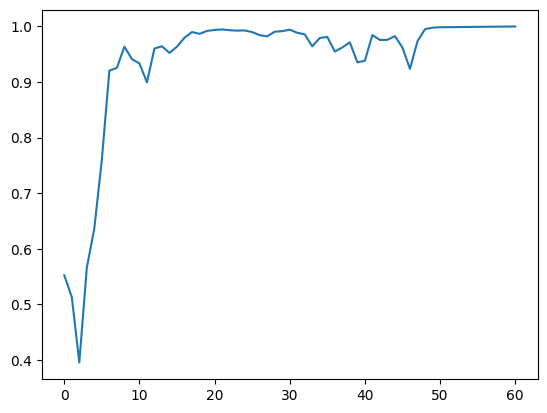

In [96]:
plt.plot(deltas)

In [151]:
# Function to calculate the Black-Scholes call option price
def calculate_option_price(S, K, r, t, sigma, option_type="call"):
    d1 = (math.log(S / K) + (r + (sigma ** 2) / 2) * t) / (sigma * math.sqrt(t))
    d2 = d1 - sigma * math.sqrt(t)
    
    call_price = S * norm_cdf(d1) - K * math.exp(-r * t) * norm_cdf(d2)

    # put price
    put_price = K * math.exp(-r * t) * norm_cdf(-d2) - S * norm_cdf(-d1)

    if option_type == "call":
        return call_price
    elif option_type == "put":
        return put_price
    else:
        print("Please enter a valid option type: 'call' or 'put'")
        return None
    

def calculate_option_delta(S, K, r, t, sigma):
    d1 = (math.log(S / K) + (r + (sigma ** 2) / 2) * t) / (sigma * math.sqrt(t))
    delta = math.exp(-r * t) * norm_cdf(d1)
    return delta


# Example usage
initial_stock_price = stocks[0]
strike_price = stocks[0]
risk_free_rate = 0.05
time_to_maturity = len(stocks) / 252
volatility = 0.237

initial_delta = calculate_option_delta(initial_stock_price, strike_price, risk_free_rate, time_to_maturity, volatility)
theoretical_option_price = calculate_option_price(initial_stock_price, strike_price, risk_free_rate, time_to_maturity, volatility, option_type="call")

deltas = [initial_delta]

shares_held = [initial_delta * initial_stock_price]
cash_flows = [0]
step_size = 5
for i, price in enumerate(stocks[1::step_size]):
    delta = calculate_option_delta(price, strike_price, risk_free_rate, time_to_maturity - (i*step_size / 252), volatility)
    delta_diff = delta - deltas[-1]
    deltas.append(delta)

    shares_to_trade = delta_diff * price
    shares_held.append(shares_held[-1] + shares_to_trade)
    cash_flow = math.exp(time_to_maturity - (i / 252) * risk_free_rate) * (theoretical_option_price - (delta - deltas[i-1]) * price)
    cash_flows.append(cash_flow)
    


In [152]:
deltas

[0.557596477548099,
 0.5309311004466983,
 0.8489695221895689,
 0.825615833548634,
 0.9336522583450574,
 0.9905707978616276,
 0.9420548227768364,
 0.9523575539244719,
 0.8863872451866744,
 0.9373080324176267,
 0.8421878240573214,
 0.9962029811184839,
 0.9987092223134147]

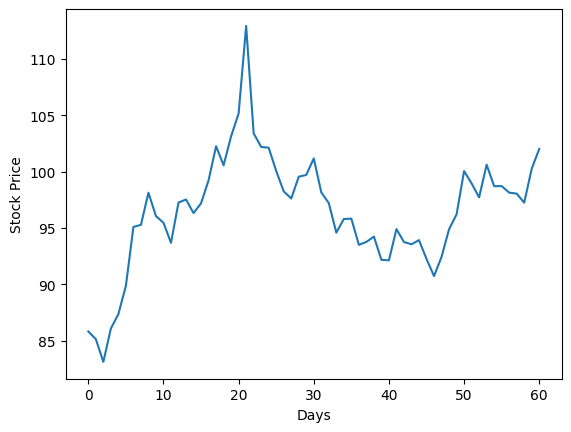

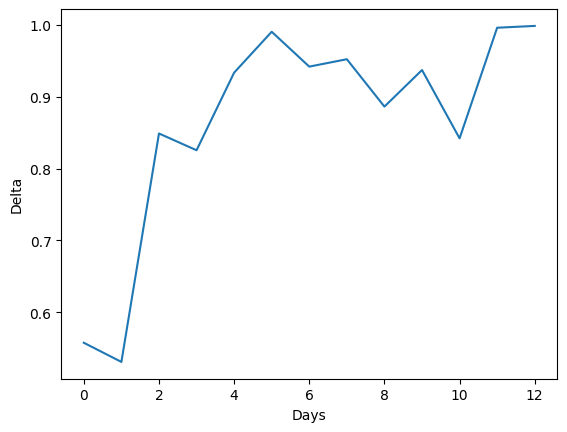

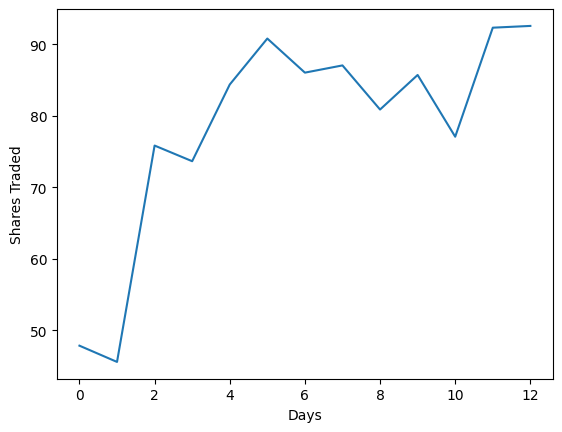

Text(0, 0.5, 'Cash Flows')

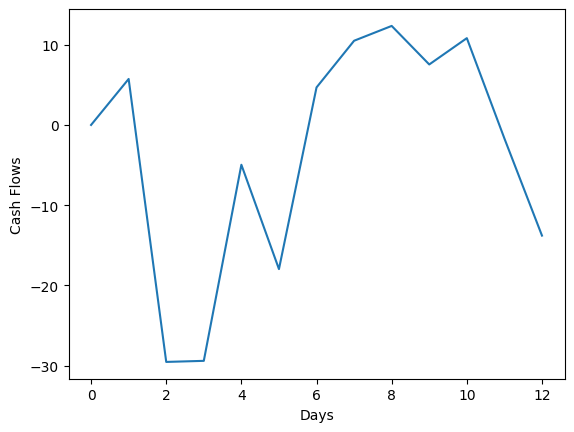

In [153]:
plt.plot(stocks)
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.show()
plt.plot(deltas)
plt.xlabel("Days")
plt.ylabel("Delta")
plt.show()
plt.plot(shares_held)
plt.xlabel("Days")
plt.ylabel("Shares Traded")
plt.show()
plt.plot(cash_flows)
plt.xlabel("Days")
plt.ylabel("Cash Flows")